In [1]:
# default_exp samples

# Sample Layouts

<br>

### Imports

In [2]:
#exports
import json
import numpy as np
import pandas as pd

import requests

In [3]:
import matplotlib.pyplot as plt
import FEAutils as hlp

from IPython.display import JSON

<br>

### Input Data

In [4]:
wind_farms_dir = '../data/endpoints/sites'

<br>

### Retrieving Wind Turbine Coordinates

We'll start by retrieving the wind farm data available from the crown estate wind resource map. We could use sources such as OpenStreetMap but the Crown Estate is a better primary source for this work.

In [5]:
crown_estate_data_url = 'https://raw.githubusercontent.com/OSUKED/Crown-Estate-Watch/master/data/wind_farm_data.json'

crown_estate_data = requests.get(crown_estate_data_url).json()

JSON(crown_estate_data)

<IPython.core.display.JSON object>

<br>

Next we'll create a function for cleaning the turbine coordinates from a single wind farm

In [6]:
#exports
def clean_turbine_coords(turbine_coords):
    if turbine_coords == '':
        return {'latitude': [], 'longitude': []}
    
    turbine_coords = (pd
                      .Series(turbine_coords.replace(';"', '; "').split('; '))
                      .str.replace('"', '')
                      .str.replace(';', '')
                      .str.split(',')
                      .apply(pd.Series)
                      .rename(columns={
                          0: 'latitude', 
                          1: 'longitude'
                      })
                      .astype(float)
                      .to_dict(orient='list')
                     )
    
    return turbine_coords

In [7]:
turbine_coords = crown_estate_data['WindFarms'][0]['TurbineCordinates'] 

df_turbine_coords = pd.DataFrame(clean_turbine_coords(turbine_coords))

df_turbine_coords.head()

,latitude,longitude
0,-3.700517,54.771500
1,-3.693450,54.769917
2,-3.709333,54.769167
3,-3.703133,54.767600
4,-3.696267,54.765917


<br>

We'll now repeat this for all sites and filter out those that have no coordinate data

In [8]:
#exports
def retrieve_turbine_coords(crown_estate_data):
    # Extracting turbine coordinates
    ce_id_to_turbine_coords = {
        wf['Id']: clean_turbine_coords(wf['TurbineCordinates'])
        for wf 
        in crown_estate_data['WindFarms'] 
        if 'TurbineCordinates' in wf.keys()
    }

    # Removing empty coordinates
    ce_id_to_turbine_coords = {
        id_: turbine_coords 
        for id_, turbine_coords 
        in ce_id_to_turbine_coords.items() 
        if len(turbine_coords['latitude']) > 0
    }
    
    return ce_id_to_turbine_coords

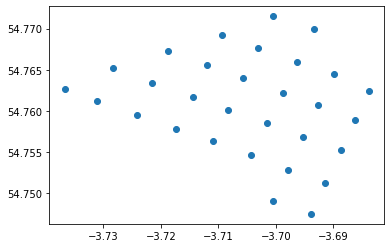

In [9]:
ce_id_to_turbine_coords = retrieve_turbine_coords(crown_estate_data)

latitudes, longitudes = ce_id_to_turbine_coords['RREW-1'].values()

plt.scatter(latitudes, longitudes)

<br>

To get a high-level overview of what our data looks like we can plot random wind farms

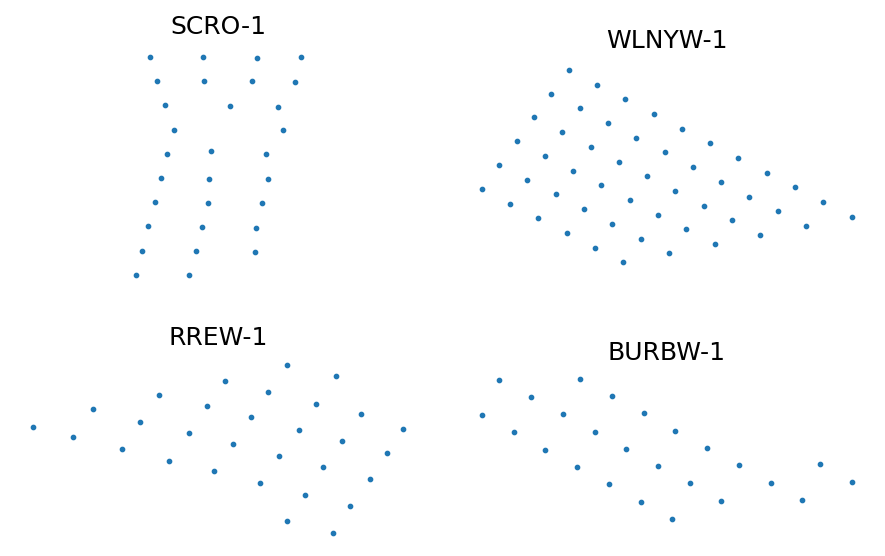

In [10]:
fig, axs = plt.subplots(dpi=150, nrows=2, ncols=2)
axs = axs.flatten()

sample_ids = np.random.choice(list(ce_id_to_turbine_coords.keys()), len(axs), replace=False)

for ax_idx, sample_id in enumerate(sample_ids):
    ax = axs[ax_idx]
    latitudes, longitudes = ce_id_to_turbine_coords[sample_id].values()
    
    ax.scatter(latitudes, longitudes, s=3)
    ax.set_title(sample_id)
    
for ax in axs:
    hlp.hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')

fig.tight_layout(h_pad=2, w_pad=2)

<br>

Lincs wind farm looks like it has a particularly bizarre layout, that is until it's plotted alongside the neighbouring wind farms of Lynn and Inner Dowsing. For groups of sites such as these, the layouts we generate are likely to differ significantly from reality due to the way we separate them.

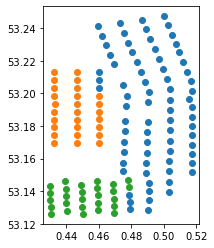

In [11]:
wf_group = ['LNCSW', 'INNDW-1', 'LYNNW-1']

for wf in wf_group:
    latitudes, longitudes = ce_id_to_turbine_coords[wf].values()
    plt.scatter(latitudes, longitudes)
    plt.gca().set_aspect('equal', adjustable='box')

<br>

We'll now create a mapping from the crown estate wind farm id to the relevant substation coordinates

N.b. The Overpass-Turbo query used can be found [here](https://overpass-turbo.eu/s/13UC)

In [28]:
ce_id_to_substation_coords = {
    'LARYO': {'latitude': [1.438, 1.531], 'longitude': [51.631, 51.604]}, # manual based on image from https://www.escaeu.org/articles/submarine-power-cables/
    'HOWAO': {'latitude': [1.714, 1.8955, 2.102], 'longitude': [53.89, 53.878, 53.878]}, # manual based on image from p4 - https://www.ofgem.gov.uk/system/files/docs/2018/10/hornsea_one_project_presentation.pdf
    'GYMRW': {'latitude': [-3.624, -3.54], 'longitude': [53.4372, 53.466]}, # manual based on image from https://www.kinewell.co.uk/gwynt-y-mor
    'RMPNO': {'latitude': [1.947, 1.959, 1.884, 1.981], 'longitude': [51.908, 51.9655, 51.919, 51.779]}, # manual based on image from p16 - http://nearyou.imeche.org/docs/greater-manchester-area-past-presentations/offshore-wind.pdf
    'RMPNO': {'latitude': [-0.259818], 'longitude': [50.692888]}, # https://www.rampionoffshore.com/app/uploads/2017/06/offshore-substation.json - this was found looking at the requests for this page - https://www.rampionoffshore.com/wind-farm/map/
    'WDNSW': {'latitude': [-3.4337], 'longitude': [53.989]}, # manual based on image from https://www.sintef.no/globalassets/project/eera-deepwind2016/presentations/x2_merz.pdf
    'THNTW': {'latitude': [1.621919], 'longitude': [51.4375182]}, # overpass, then confirmed here - https://www.researchgate.net/publication/318893622_Optimizing_wind_farm_cable_routing_considering_power_losses/figures?lo=1
    'RCBKO': {'latitude': [0.808, 0.867], 'longitude': [53.295, 53.256]}, # manual based on image from https://www.ofgem.gov.uk/system/files/docs/2016/10/race_bank_presentation.pdf
    'SHRSO': {'latitude': [1.175819, 1.120607], 'longitude': [53.126704, 53.144141]}, # overpass
    'LNCSW': {'latitude': [0.4906076], 'longitude': [53.188448]}, # overpass
    'WLNYW-1': {'latitude': [-3.5010924], 'longitude': [54.0442153]} # overpass
}

In [36]:
# s_num_turbines = pd.Series({k: len(v['latitude']) for k, v in ce_id_to_turbine_coords.items()}).sort_values(ascending=False)

# s_num_turbines.head(10)

In [37]:
# wf_id_to_name = {wf['Id']: wf['Name'] for wf in crown_estate_data['WindFarms']}

# pd.Series({k: wf_id_to_name[k] for k in ce_id_to_turbine_coords.keys()}).loc[s_num_turbines.iloc[9:].head(10).index]

In [31]:
# latitudes, longitudes = ce_id_to_turbine_coords['WLNYW-1'].values()
# plt.scatter(latitudes, longitudes, s=3)
# plt.gca().set_aspect('equal', adjustable='box')

# plt.scatter([-3.5010924], [54.0442153], s=3) 

<br>

### Saving Data

In [32]:
ce_id_to_osuked_id = {
    'RREW-1': 10235,
    'RRWW-1': 10236,
    'WLNYW-1': 10246,
    'WLNYO-2': 10247,
    'WDNSW': 10251,
    'BOWLW-1': 10156,
    'OMNDO-1': 10229,
    'GYMRW': 10206,
    'BRBEO-1': 10170,
    'BURBW-1': 10171,
    'GNFSW-1': 10204,
    'GNFSW-2': 10205,
    'LARYO': 10221,
    'THNTW': 10242,
    'GRGBW': 10201,
    'SHRSO': 10239,
    'LNCSW': 10219,
    'DDGNO': 10185,
    'HMGTO': 10214,
    'WTMSO-1': 10248,
    'GAOFO': 10194,
    'RMPNO': 10234,
    'WLNYO-3': 10245,
    'RCBKO': 10233,
    'BODW-1': 10165,
    'HYWND': 10215,
}

In [34]:
for ce_id, osuked_id in ce_id_to_osuked_id.items():
    with open(f'{wind_farms_dir}/{osuked_id}.json', 'r') as fp:
        wf = json.load(fp)
        
    if ce_id in ce_id_to_turbine_coords.keys():
        wf['turbine_coords'] = ce_id_to_turbine_coords[ce_id]
    
    if ce_id in ce_id_to_substation_coords.keys():
        wf['substation_coords'] = ce_id_to_substation_coords[ce_id]
        
    with open(f'{wind_farms_dir}/{osuked_id}.json', 'w') as fp:
        json.dump(wf, fp)